In [1]:
from SL_C0de.grid import ICE_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import TOPOGRAPHIC_TIME_GRID
from SL_C0de.grid import OCEAN_TIME_GRID

maxdeg=512


Input_way='C:/Users/ahenry01/Desktop/Python_code/Interpolated_grid'
ice_time_grid=ICE_TIME_GRID(from_file=(True,Input_way+'/ICE/ice_ICE6G_26_512'))
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,Input_way+'/SED/sed_AYS1_26_512'))
topo_time_grid=TOPOGRAPHIC_TIME_GRID(from_file=(True,Input_way+'/TOPO/topo_topo_SL_26_512'))

KeyError: 'maxdeg'

# For the initialization, we need to update the ice as a corrected ice

In [ ]:
ocean_time_grid=OCEAN_TIME_GRID()
ocean_time_grid.evaluate_ocean(topo_time_grid.height_time_grid[0,:,:])

In [ ]:
ice_time_grid.ice_correction(topo_time_grid,ocean_time_grid)
ice_time_grid.timegrdtotimecoeff()

# For the model computation, we need the love numbers. 

In [ ]:
from SL_C0de.love import LOVE
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
maxdeg=512
stop=122 # define the number of time steps
step=1
time_step=np.arange(start=stop,stop=-step,step=-step)
love_number=LOVE(maxdeg,'C:/Users/ahenry01/Desktop/Python_code/SL_C0de_data/VM5a_122',time_step,6371000,5.9742e24)
love_number.calc_beta_R()

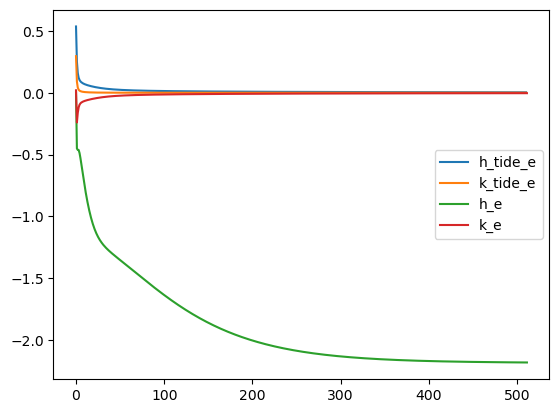

In [ ]:
import matplotlib.pyplot as plt
plt.plot(love_number.h_tide_e[1:],label='h_tide_e')
plt.plot(love_number.k_tide_e[1:],label='k_tide_e')
plt.plot(love_number.h_e,label='h_e')
plt.plot(love_number.k_e,label='k_e')
plt.legend()
plt.show()

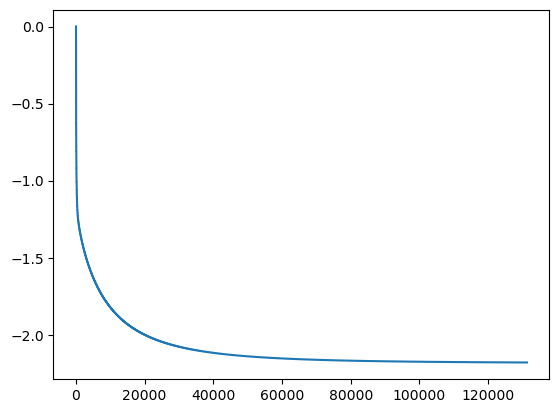

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(love_number.h)
plt.show()

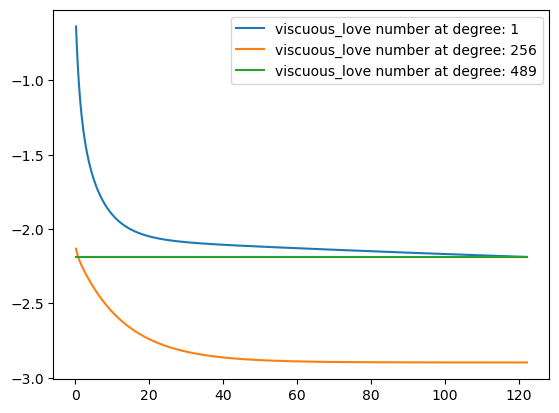

In [ ]:
import matplotlib.pyplot as plt
from numpy.matlib import repmat
plt.plot(love_number.love_time,love_number.h_ve[1:-1,1],label='viscuous_love number at degree: ' + str(1))
plt.plot(love_number.love_time,love_number.h_ve[1:-1,int(love_number.h_ve.shape[1]/4)],label='viscuous_love number at degree: ' + str(int(love_number.h_ve.shape[1]/4)))
plt.plot(love_number.love_time,love_number.h_ve[1:-1,-1],label='viscuous_love number at degree: ' + str(love_number.h_ve.shape[0]-2))
plt.legend()
plt.show()

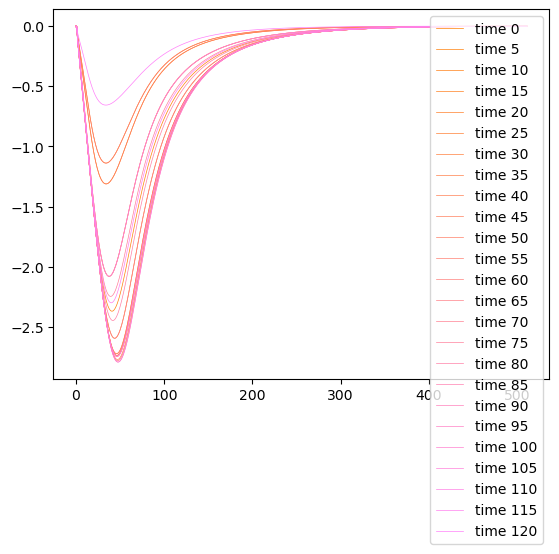

In [ ]:
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import math
for t_it in range(0,len(time_step)-1,5):
    plt.plot(love_number.beta_R_l[-1,t_it].T/(4*math.pi),color=(1,.5,t_it/len(time_step)),label=f'time {t_it}',linewidth=0.5)
plt.legend()
plt.show()

# Now we have defined the love numbers and adapted them to our model, we can calculate the subsidence and Geoïd deformation

In [ ]:
from SL_C0de.Load import LOAD

In [ ]:
load=LOAD(maxdeg,time_step)

In [ ]:
t_it=20
if t_it==1 :
    load.calc_viscuous_load(ice_time_grid.height_time_coeff[0].copy()*ice_time_grid.rho,love_number.beta_R_l_coeff,t_it-1)
else :
    load.calc_viscuous_load(ice_time_grid.height_time_coeff[:t_it-1].copy()*ice_time_grid.rho,love_number.beta_R_l_coeff,t_it-1)
load.V_lm.maxdeg=512
load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
hd_visc=load.V_lm.coefftogrdhd(1024)

In [ ]:
from SL_C0de.spharm import sphericalobject
subs_e=sphericalobject(coeff=ice_time_grid.height_time_coeff[:t_it].sum(0)*ice_time_grid.rho*love_number.h*love_number.T.coeff)
subs_e.maxdeg=512
hd_elast=subs_e.coefftogrdhd(1024)

In [ ]:
total_subsidence=hd_elast+hd_visc

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_14932\1418012619.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


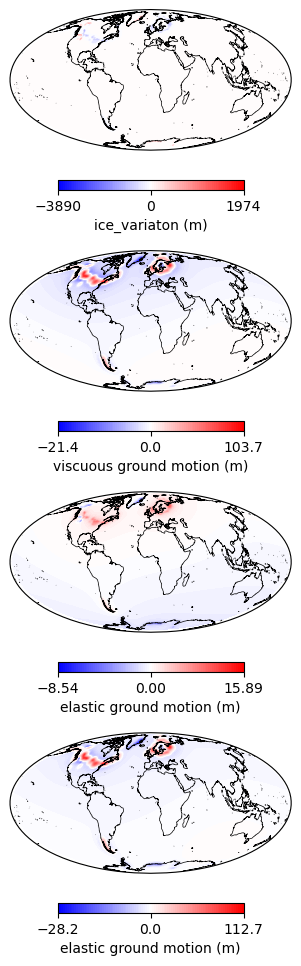

In [ ]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm1 = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
ax1  = plt.subplot(411, projection=ccrs.Mollweide())
ax1.set_global()
colormap = cmap
m1 = ax1.imshow(ice_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm1)
cbar1=plt.colorbar(mappable=m1, orientation="horizontal", shrink=0.2,ax=ax1)
cbar1.set_label('ice_variaton (m)')
cbar1.set_ticks([ice_time_grid.height_time_grid[:t_it,:,:].sum(0).min(), 0, ice_time_grid.height_time_grid[:t_it,:,:].sum(0).max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm2 = colors.TwoSlopeNorm(vmin=hd_visc.min(),vmax=hd_visc.max(),vcenter=0)
ax2  = plt.subplot(412, projection=ccrs.Mollweide())
ax2.set_global()
colormap = cmap
m2 = ax2.imshow(hd_visc, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm2)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.2,ax=ax2)
cbar2.set_label('viscuous ground motion (m)')
cbar2.set_ticks([hd_visc.min(), 0, hd_visc.max()])
ax2.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax2.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm3 = colors.TwoSlopeNorm(vmin=hd_elast.min(),vmax=hd_elast.max(),vcenter=0)
ax3  = plt.subplot(413, projection=ccrs.Mollweide())
ax3.set_global()
colormap = cmap
m3 = ax3.imshow(hd_elast, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
cbar3.set_label('elastic ground motion (m)')
cbar3.set_ticks([hd_elast.min(), 0, hd_elast.max()])
ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm4 = colors.TwoSlopeNorm(vmin=total_subsidence.min(),vmax=total_subsidence.max(),vcenter=0)
ax4  = plt.subplot(414, projection=ccrs.Mollweide())
ax4.set_global()
colormap = cmap
m4 = ax4.imshow(total_subsidence, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm4)
cbar4=plt.colorbar(mappable=m4, orientation="horizontal", shrink=0.2,ax=ax4)
cbar4.set_label('Total ground motion (m)')
cbar4.set_ticks([total_subsidence.min(), 0, total_subsidence.max()])
ax4.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax4.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [ ]:
fig.savefig('test.pdf')

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2888\873594385.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2=cm.get_cmap('bwr', 100)
C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2888\873594385.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1=cm.get_cmap('Blues', 100)


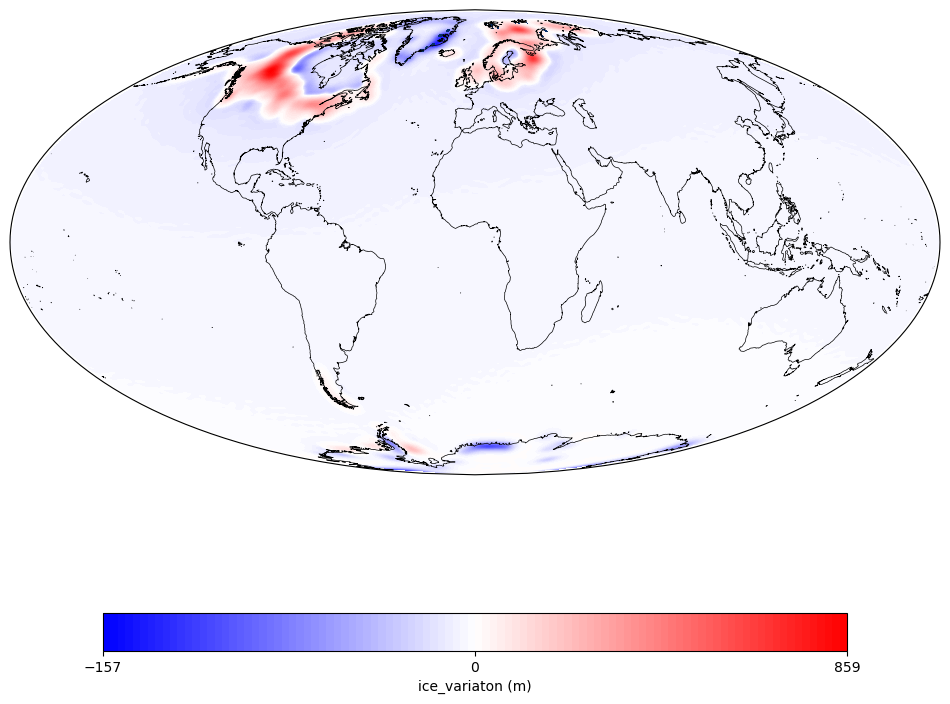

In [ ]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors

cmap2=cm.get_cmap('bwr', 100)
cmap1=cm.get_cmap('Blues', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

clean_grid=ice_time_grid.height_time_grid[t_it,:,:].copy()
clean_grid[clean_grid<=0]=0
clean_grid[clean_grid>0]=1

norm1 = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
norm2 = colors.TwoSlopeNorm(vmin=total_subsidence.min(),vmax=total_subsidence.max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(total_subsidence, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap2, interpolation="gaussian",norm=norm2)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
cbar2.set_ticks([total_subsidence.min(), 0, total_subsidence.max()])
m1 = ax1.imshow(clean_grid, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap1, interpolation="none",norm=norm1,alpha=clean_grid)
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [ ]:
fig.savefig('ice_cap.pdf')

# Calculating_every time_step

In [ ]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (ice_time_grid.time_step_number) :
    if t_it==0:
        hd_visc=np.zeros((1025,1025*2))
    elif t_it==1 :
        load.calc_viscuous_load(ice_time_grid.height_time_coeff[0]*ice_time_grid.rho,love_number.beta_R_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    else :
        load.calc_viscuous_load(ice_time_grid.height_time_coeff[:t_it-1]*ice_time_grid.rho,love_number.beta_R_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    if t_it==0 :
        subs_e=sphericalobject(coeff=ice_time_grid.height_time_coeff[0]*ice_time_grid.rho*(love_number.h)*love_number.T.coeff)
    else :
        subs_e=sphericalobject(coeff=ice_time_grid.height_time_coeff[:t_it].sum(0)*ice_time_grid.rho*(love_number.h)*love_number.T.coeff)
    subs_e.maxdeg=64
    hd_elast=subs_e.coefftogrdhd(1024)

    total_subs=hd_elast+hd_visc

    norm3 = colors.TwoSlopeNorm(vmin=-500,vmax=100,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(total_subs, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    if t_it==0 :
        c=ax3.contour(ice_time_grid.elons,ice_time_grid.lats[::-1],ice_time_grid.height_time_grid[0,:,:],[0],linewidths=2,transform=ccrs.PlateCarree(),colors='b')
    else :
        c=ax3.contour(ice_time_grid.elons,ice_time_grid.lats[::-1],ice_time_grid.height_time_grid[:t_it,:,:].sum(0),[0],linewidths=2,transform=ccrs.PlateCarree(),colors='b')
    ax3.plot([-100,-200],[-100,-200],linewidth=2,color='b',label='ice extent')
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(ice_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-500, 0, 100])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    ax3.legend()
    fig.savefig('Results/ice'+str(t_it))

    plt.clf()
    

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_1912\785860.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

In [ ]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (ice_time_grid.time_step_number) :
    norm3 = colors.TwoSlopeNorm(vmin=-3000,vmax=3000,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(ice_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(ice_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-3000,0,3000])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    fig.savefig('Results_ice/ice'+str(t_it))

    plt.clf()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_13352\747978904.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

# Now we have worked on the ice we can try to see what's going on with the sediments. 

In [10]:
from SL_C0de.Load import LOAD

In [11]:
load=LOAD(maxdeg,time_step)

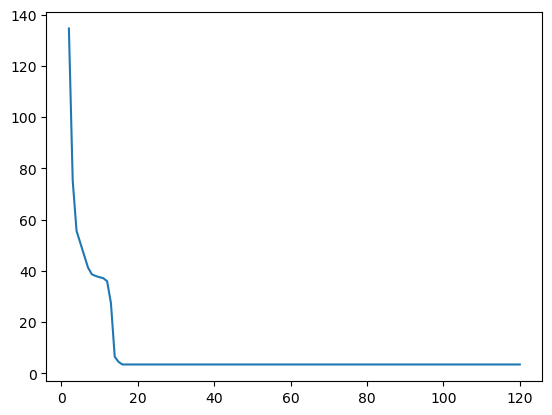

In [12]:
plt.plot(sed_time_grid.time_step,sed_time_grid.height_time_grid.sum(-1).sum(-1).cumsum())

In [13]:
sed_time_grid.timegrdtotimecoeff()

In [22]:
t_it=115
load.calc_viscuous_load(-sed_time_grid.height_time_coeff[:t_it-1,:]*sed_time_grid.rho,love_number.beta_l,t_it-1)
load.V_lm.maxdeg=64
load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
hd_visc=load.V_lm.coefftogrdhd(1024)

In [23]:
from SL_C0de.spharm import sphericalobject
subs_e=sphericalobject(coeff=-sed_time_grid.height_time_coeff[:t_it,:].sum(0)*sed_time_grid.rho*(love_number.k-love_number.h)*love_number.T.coeff)
subs_e.maxdeg=64
hd_elast=subs_e.coefftogrdhd(1024)

In [24]:
total_subsidence=hd_elast+hd_visc

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_1656\310232321.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


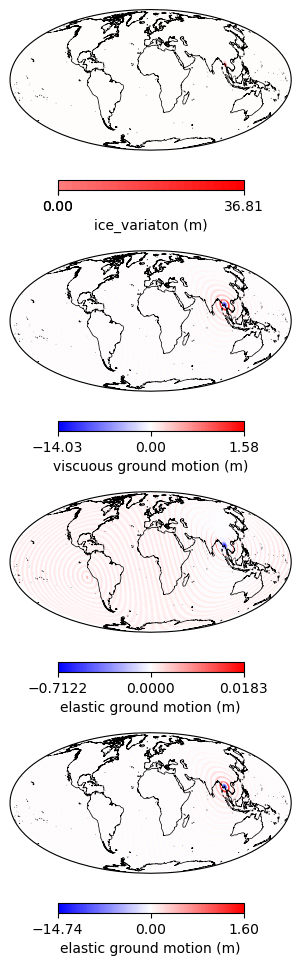

In [25]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm1 = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
ax1  = plt.subplot(411, projection=ccrs.Mollweide())
ax1.set_global()
colormap = cmap
m1 = ax1.imshow(sed_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm1)
cbar1=plt.colorbar(mappable=m1, orientation="horizontal", shrink=0.2,ax=ax1)
cbar1.set_label('ice_variaton (m)')
cbar1.set_ticks([sed_time_grid.height_time_grid[:t_it,:,:].sum(0).min(), 0, sed_time_grid.height_time_grid[:t_it,:,:].sum(0).max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm2 = colors.TwoSlopeNorm(vmin=hd_visc.min(),vmax=hd_visc.max(),vcenter=0)
ax2  = plt.subplot(412, projection=ccrs.Mollweide())
ax2.set_global()
colormap = cmap
m2 = ax2.imshow(hd_visc, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm2)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.2,ax=ax2)
cbar2.set_label('viscuous ground motion (m)')
cbar2.set_ticks([hd_visc.min(), 0, hd_visc.max()])
ax2.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax2.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm3 = colors.TwoSlopeNorm(vmin=hd_elast.min(),vmax=hd_elast.max(),vcenter=0)
ax3  = plt.subplot(413, projection=ccrs.Mollweide())
ax3.set_global()
colormap = cmap
m3 = ax3.imshow(hd_elast, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
cbar3.set_label('elastic ground motion (m)')
cbar3.set_ticks([hd_elast.min(), 0, hd_elast.max()])
ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

norm4 = colors.TwoSlopeNorm(vmin=total_subsidence.min(),vmax=total_subsidence.max(),vcenter=0)
ax4  = plt.subplot(414, projection=ccrs.Mollweide())
ax4.set_global()
colormap = cmap
m4 = ax4.imshow(total_subsidence, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm4)
cbar4=plt.colorbar(mappable=m4, orientation="horizontal", shrink=0.2,ax=ax4)
cbar4.set_label('elastic ground motion (m)')
cbar4.set_ticks([total_subsidence.min(), 0, total_subsidence.max()])
ax4.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax4.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [44]:
fig.savefig('sed_test.pdf')

In [58]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (sed_time_grid.time_step_number) :
    norm3 = colors.TwoSlopeNorm(vmin=-1,vmax=100,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(sed_time_grid.height_time_grid[:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(sed_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-1,0,100])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    fig.savefig('Results_sed/sed'+str(t_it))

    plt.clf()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_23364\138224163.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

In [26]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
for t_it in range (sed_time_grid.time_step_number) :
    if t_it==0:
        hd_visc=np.zeros((1025,1025*2))
    elif t_it==1 :
        load.calc_viscuous_load(-sed_time_grid.height_time_coeff[0]*sed_time_grid.rho,love_number.beta_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    else :
        load.calc_viscuous_load(-sed_time_grid.height_time_coeff[:t_it-1]*sed_time_grid.rho,love_number.beta_l,t_it-1)
        load.V_lm.maxdeg=64
        load.V_lm.coeff=load.V_lm.coeff*love_number.T.coeff
        hd_visc=load.V_lm.coefftogrdhd(1024)
    if t_it==0 :
        subs_e=sphericalobject(coeff=-sed_time_grid.height_time_coeff[0]*sed_time_grid.rho*(love_number.k-love_number.h)*love_number.T.coeff)
    else :
        subs_e=sphericalobject(coeff=-sed_time_grid.height_time_coeff[:t_it].sum(0)*sed_time_grid.rho*(love_number.k-love_number.h)*love_number.T.coeff)
    subs_e.maxdeg=64
    hd_elast=subs_e.coefftogrdhd(1024)

    total_subs=hd_elast+hd_visc

    norm3 = colors.TwoSlopeNorm(vmin=-20,vmax=2,vcenter=0)
    ax3  = plt.subplot(111, projection=ccrs.Mollweide())
    ax3.set_global()
    colormap = cmap
    m3 = ax3.imshow(total_subs, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=colormap, interpolation="gaussian",norm=norm3)
    # if t_it==0 :
    #     c=ax3.contour(sed_time_grid.elons,sed_time_grid.lats[::-1],sed_time_grid.height_time_grid[0,:,:],[0],linewidths=2,transform=ccrs.PlateCarree(),colors='b')
    # else :
    #     c=ax3.contour(sed_time_grid.elons,ice_time_grid.lats[::-1],sed_time_grid.height_time_grid[:t_it,:,:].sum(0),[0],linewidths=2,transform=ccrs.PlateCarree())
    #ax3.plot([-100,-200],[-100,-200],linewidth=2,color='b',label='ice extent')
    cbar3=plt.colorbar(mappable=m3, orientation="horizontal", shrink=0.2,ax=ax3)
    cbar3.set_label('elastic ground motion at ' + str(sed_time_grid.time_step[t_it]) + ' (m)')
    cbar3.set_ticks([-20, 0, 2])
    ax3.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
    ax3.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)
    # ax3.legend()
    fig.savefig('Results_sed_def/ice'+str(t_it))

    plt.clf()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_1656\2616275074.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


<Figure size 1200x1200 with 0 Axes>

# Calculating the Subsidence from output files

In [1]:
from SL_C0de.grid import OCEAN_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import ICE_TIME_GRID

Input_way='C:/Users/ahenry01/Desktop/Python_code/Output_grid/VM5a_122'

Output_way=Input_way+'/'

ocean_time_grid=OCEAN_TIME_GRID(from_file=(True,Input_way+'/OCEAN_122_512'))
ice_time_grid=ICE_TIME_GRID(from_file=(True,Input_way+'/ice_ICE6G_122_512'))

Input_way='C:/Users/ahenry01/Desktop/Python_code/Interpolated_grid'
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,Input_way+'/SED/sed_AYS1_122_512'))

from SL_C0de.love import LOVE
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
a=6371000
Me=5.9742e24
love_number=LOVE(ice_time_grid.maxdeg,'C:/Users/ahenry01/Desktop/Python_code/SL_C0de_data/VM5a_122',ice_time_grid.time_step,a,Me)

In [2]:
from SL_C0de.grid import LOAD_TIME_GRID
beta_l=love_number.beta_R_l
sed_time_grid.timegrdtotimecoeff()
ice_time_grid.timegrdtotimecoeff()
sdelL=ice_time_grid.height_time_coeff*ice_time_grid.rho+sed_time_grid.height_time_coeff*sed_time_grid.rho+ocean_time_grid.height_time_coeff*ocean_time_grid.rho
total_load_time_grid=LOAD_TIME_GRID(sdelL=sdelL,beta_l=beta_l,E=love_number.h_e,a=a,Me=Me,time_step=ice_time_grid.time_step,maxdeg=ice_time_grid.maxdeg,grid_name='TOTAL_LOAD_122_512')


In [3]:
total_load_time_grid.calc_elastic_time()
total_load_time_grid.calc_viscuous_time(backend=True)

viscuous calculation at 121.0 kyr done
viscuous calculation at 120.0 kyr done
viscuous calculation at 119.0 kyr done
viscuous calculation at 118.0 kyr done
viscuous calculation at 117.0 kyr done
viscuous calculation at 116.0 kyr done
viscuous calculation at 115.0 kyr done
viscuous calculation at 114.0 kyr done
viscuous calculation at 113.0 kyr done
viscuous calculation at 112.0 kyr done
viscuous calculation at 111.0 kyr done
viscuous calculation at 110.0 kyr done
viscuous calculation at 109.0 kyr done
viscuous calculation at 108.0 kyr done
viscuous calculation at 107.0 kyr done
viscuous calculation at 106.0 kyr done
viscuous calculation at 105.0 kyr done
viscuous calculation at 104.0 kyr done
viscuous calculation at 103.0 kyr done
viscuous calculation at 102.0 kyr done
viscuous calculation at 101.0 kyr done
viscuous calculation at 100.0 kyr done
viscuous calculation at 99.0 kyr done
viscuous calculation at 98.0 kyr done
viscuous calculation at 97.0 kyr done
viscuous calculation at 96.0

In [4]:
total_load_time_grid.save(save_way=Output_way)

In [4]:
total_load_time_grid.clean_memory()
total_load_time_grid.height_time_coeff=total_load_time_grid.viscuous_deformation[1:,:]+total_load_time_grid.elastic_deformation
total_load_time_grid.height_time_coeff=np.concatenate((np.diff(total_load_time_grid.height_time_coeff,axis=0),np.expand_dims(total_load_time_grid.height_time_coeff[-1,:],axis=0)))

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2592\3675233411.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)
c:\Users\ahenry01\miniconda3\envs\SL_C0de\Lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)


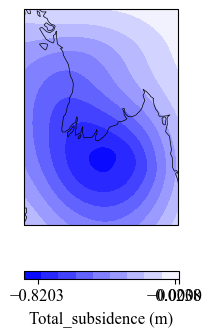

In [5]:
import cartopy
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

t_it=np.where(ocean_time_grid.time_step==0)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
total_load_time_grid.coeff_from_step(t_it-2)
grid,lon_hd,lat_hd=total_load_time_grid.coefftogrdhd(4000)
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(4,4), facecolor="none")
area=(93,98,13,20)

#lat_hd=lat_hd[::-1]
#find the closest position :
lon_lim_min=np.abs(lon_hd-area[0]).argmin()
lon_lim_max=np.abs(lon_hd-area[1]).argmin()
lat_lim_min=np.abs(lat_hd-area[2]).argmin()
lat_lim_max=np.abs(lat_hd-area[3]).argmin()
lon=lon_hd[lon_lim_min:lon_lim_max+1]
lat=lat_hd[lat_lim_min:lat_lim_max+1]
grid=grid[lat_lim_min:lat_lim_max+1,lon_lim_min:lon_lim_max+1]

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.set_extent(area)
m2 = ax1.contourf(lon,lat,grid, origin='lower', transform=ccrs.PlateCarree(),extent=area, zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.5)
cbar2.set_label('Total_subsidence (m)')
cbar2.set_ticks([grid.min(), 0, grid.max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2592\87580146.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


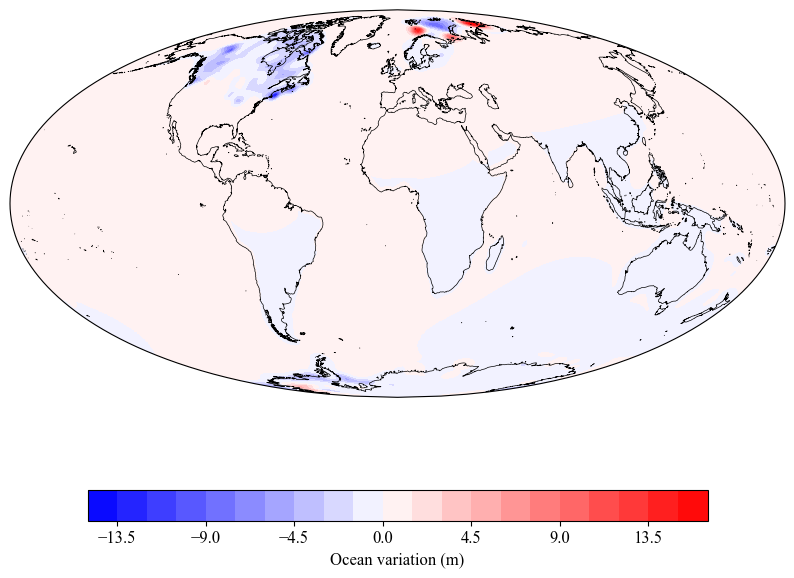

In [6]:
import cartopy
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

t_it=np.where(ocean_time_grid.time_step==27)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
total_load_time_grid.coeff_from_step(t_it-2)

grid,lon_hd,lat_hd=total_load_time_grid.coefftogrdhd(512)
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(10,8), facecolor="none")


norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.contourf(lon_hd,lat_hd,grid,levels=20, origin='lower', transform=ccrs.PlateCarree(), zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Ocean variation (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [6]:
beta_l=love_number.beta_G_l
total_geoid_time_grid=LOAD_TIME_GRID(sdelL=sdelL,beta_l=beta_l,E=love_number.k_e,a=a,Me=Me,time_step=ice_time_grid.time_step,maxdeg=ice_time_grid.maxdeg,grid_name='TOTAL_GEOID_122_512')
total_geoid_time_grid.calc_elastic_time()
total_geoid_time_grid.calc_viscuous_time(backend=True)

viscuous calculation at 121.0 kyr done
viscuous calculation at 120.0 kyr done
viscuous calculation at 119.0 kyr done
viscuous calculation at 118.0 kyr done
viscuous calculation at 117.0 kyr done
viscuous calculation at 116.0 kyr done
viscuous calculation at 115.0 kyr done
viscuous calculation at 114.0 kyr done
viscuous calculation at 113.0 kyr done
viscuous calculation at 112.0 kyr done
viscuous calculation at 111.0 kyr done
viscuous calculation at 110.0 kyr done
viscuous calculation at 109.0 kyr done
viscuous calculation at 108.0 kyr done
viscuous calculation at 107.0 kyr done
viscuous calculation at 106.0 kyr done
viscuous calculation at 105.0 kyr done
viscuous calculation at 104.0 kyr done
viscuous calculation at 103.0 kyr done
viscuous calculation at 102.0 kyr done
viscuous calculation at 101.0 kyr done
viscuous calculation at 100.0 kyr done
viscuous calculation at 99.0 kyr done
viscuous calculation at 98.0 kyr done
viscuous calculation at 97.0 kyr done
viscuous calculation at 96.0

In [7]:
total_geoid_time_grid.save(save_way=Output_way)

In [8]:
total_geoid_time_grid.clean_memory()
total_geoid_time_grid.height_time_coeff=total_geoid_time_grid.viscuous_deformation[1:,:]+total_geoid_time_grid.elastic_deformation
total_geoid_time_grid.height_time_coeff=np.concatenate((np.diff(total_geoid_time_grid.height_time_coeff,axis=0),np.expand_dims(total_geoid_time_grid.height_time_coeff[-1,:],axis=0)))

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2592\434122934.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)
c:\Users\ahenry01\miniconda3\envs\SL_C0de\Lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)


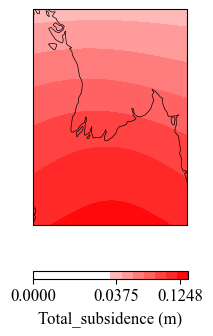

In [9]:
import cartopy
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

t_it=np.where(ocean_time_grid.time_step==0)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
total_geoid_time_grid.coeff_from_step(t_it-2)
grid,lon_hd,lat_hd=total_geoid_time_grid.coefftogrdhd(4000)
grid=-grid
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(4,4), facecolor="none")
area=(93,98,13,20)

#lat_hd=lat_hd[::-1]
#find the closest position :
lon_lim_min=np.abs(lon_hd-area[0]).argmin()
lon_lim_max=np.abs(lon_hd-area[1]).argmin()
lat_lim_min=np.abs(lat_hd-area[2]).argmin()
lat_lim_max=np.abs(lat_hd-area[3]).argmin()
lon=lon_hd[lon_lim_min:lon_lim_max+1]
lat=lat_hd[lat_lim_min:lat_lim_max+1]
grid=grid[lat_lim_min:lat_lim_max+1,lon_lim_min:lon_lim_max+1]

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.set_extent(area)
m2 = ax1.contourf(lon,lat,grid, origin='lower', transform=ccrs.PlateCarree(),extent=area, zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.5)
cbar2.set_label('Total_subsidence (m)')
cbar2.set_ticks([grid.min(), 0, grid.max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2592\1754554587.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


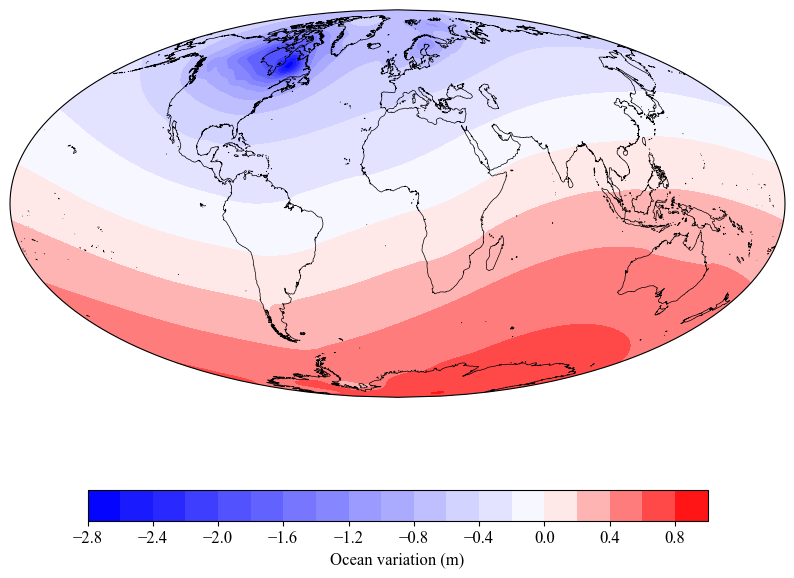

In [10]:
import cartopy
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

t_it=np.where(ocean_time_grid.time_step==0)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
total_geoid_time_grid.coeff_from_step(t_it-2)

grid,lon_hd,lat_hd=total_geoid_time_grid.coefftogrdhd(512)
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(10,8), facecolor="none")


norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.contourf(lon_hd,lat_hd,-grid,levels=20, origin='lower', transform=ccrs.PlateCarree(), zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Ocean variation (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [11]:
from SL_C0de.grid import TIME_GRID
RSL=TIME_GRID(ice_time_grid.time_step[1:],ice_time_grid.maxdeg,grid_name='RSL_122_512',height_time_coeff=total_load_time_grid.height_time_coeff-total_geoid_time_grid.height_time_coeff)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_2592\2867959035.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)
c:\Users\ahenry01\miniconda3\envs\SL_C0de\Lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)


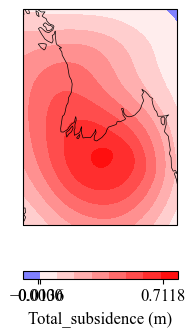

In [12]:
import cartopy
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

t_it=np.where(ocean_time_grid.time_step==0)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
RSL.coeff_from_step(t_it-2)
grid,lon_hd,lat_hd=RSL.coefftogrdhd(4000)
grid=-grid
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(4,4), facecolor="none")
area=(93,98,13,20)

#lat_hd=lat_hd[::-1]
#find the closest position :
lon_lim_min=np.abs(lon_hd-area[0]).argmin()
lon_lim_max=np.abs(lon_hd-area[1]).argmin()
lat_lim_min=np.abs(lat_hd-area[2]).argmin()
lat_lim_max=np.abs(lat_hd-area[3]).argmin()
lon=lon_hd[lon_lim_min:lon_lim_max+1]
lat=lat_hd[lat_lim_min:lat_lim_max+1]
grid=grid[lat_lim_min:lat_lim_max+1,lon_lim_min:lon_lim_max+1]

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.set_extent(area)
m2 = ax1.contourf(lon,lat,grid, origin='lower', transform=ccrs.PlateCarree(),extent=area, zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.5)
cbar2.set_label('Total_subsidence (m)')
cbar2.set_ticks([grid.min(), 0, grid.max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)